In [1]:
using PowerSpectra
using Healpix
using CSV
using Test
using LinearAlgebra
using DataFrames
using DelimitedFiles
import PowerSpectra: TT, TE, EE

using PyCall
hp = pyimport("healpy")

using PyPlot
PyPlot.svg(true);

print(Threads.nthreads(), "\n" * ENV["OMP_NUM_THREADS"])

16
16

In [2]:
theory = CSV.read("../test/data/theory.csv", DataFrame)
noise = CSV.read("../test/data/noise.csv", DataFrame)

noise.nltt .*= 4
noise.nlee .*= 4;

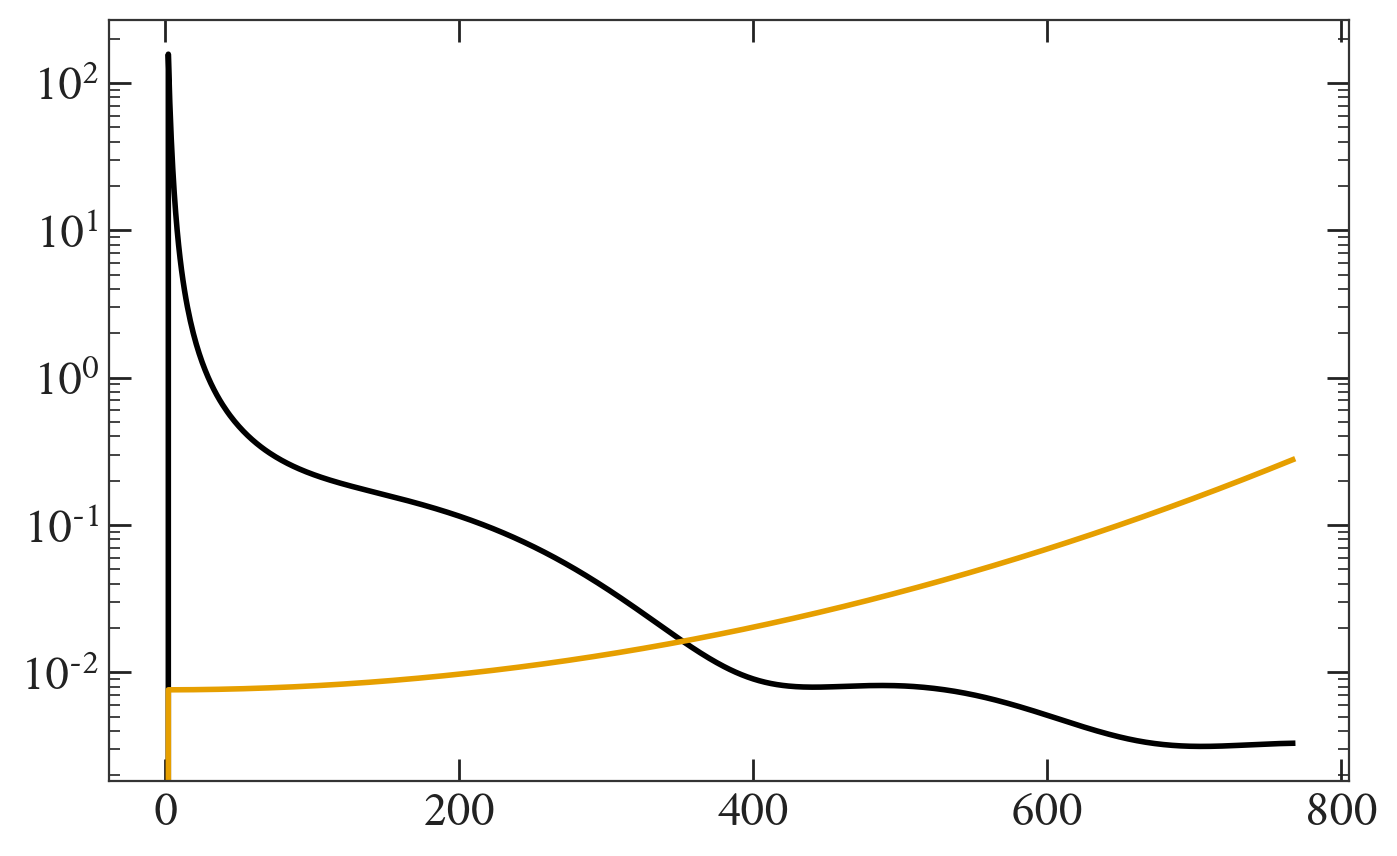

In [3]:
plot(theory.ell, theory.cltt, "-")
plot(noise.l, noise.nltt , "-")
yscale("log")
# ylim(0, 1e4)

In [4]:
nside = 256
weight_dir = "/media/science/healpy-data/full_weights/"
weights = readfullweights("$(weight_dir)/healpix_full_weights_nside_$(lpad(nside,4,'0')).fits");

In [5]:
mask1 = readMapFromFITS("../test/data/mask1_T.fits", 1, Float64)
mask2 = readMapFromFITS("../test/data/mask2_P.fits", 1, Float64);

In [6]:
lmax = 3nside-1
m1 = PolarizedHealpixMap{Float64, RingOrder}(nside)
m2 = PolarizedHealpixMap{Float64, RingOrder}(nside);
noise_buffer = Alm(lmax, lmax)
a1 = [Alm(lmax, lmax) for i in 1:3]
a2 = [Alm(lmax, lmax) for i in 1:3];

In [7]:
𝐂 = zeros(1, 1, lmax+1)
𝐍 = zeros(1, 1, lmax+1)

pwT = hp.pixwin(nside)
𝐂[1,1,:] .= theory.cltt .* pwT.^2;
𝐍[1,1,:] .= noise.nltt


function sim!(𝐂, 𝐍, a1, a2, buffer)
    # deposit signal
    synalm!(𝐂, [a1[1]])
    a2[1].alm .= a1[1].alm

    # deposit noise (independent)
    synalm!(𝐍, [buffer])
    a1[1].alm .+= buffer.alm
    synalm!(𝐍, [buffer])
    a2[1].alm .+= buffer.alm
    return nothing
end

sim! (generic function with 1 method)

In [8]:
unit_var = HealpixMap{Float64, RingOrder}(ones(nside2npix(nside)))

f1 = CovField("field1", mask1, mask1, unit_var, unit_var, unit_var)
f2 = CovField("field2", mask2, mask2, unit_var, unit_var, unit_var)
workspace = SpectralWorkspace(f1, f2)

𝐌 = mcm(workspace, "TT", f1.name, f2.name).parent;

In [9]:
using ProgressMeter

In [10]:
function fill_sim_array!(𝐂, 𝐍, sims, nside, M, mask1, mask2, pixel_weights)
    lmax = 3nside-1
    m1 = HealpixMap{Float64, RingOrder}(nside)
    m2 = HealpixMap{Float64, RingOrder}(nside)
    noise_buffer = Alm(lmax, lmax)
    a1 = [Alm(lmax, lmax) for i in 1:3]
    a2 = [Alm(lmax, lmax) for i in 1:3]
    
    @showprogress for i in 1:size(sims,2)
        sim!(𝐂, 𝐍, a1, a2, noise_buffer)
        alm2map!(a1[1], m1)
        alm2map!(a2[1], m2)
        applyweights!(m1, pixel_weights)
        applyweights!(m2, pixel_weights)
        mask!(m1, mask1)
        mask!(m2, mask2)
        map2alm!(m1, a1[1]; niter=0)
        map2alm!(m2, a2[1]; niter=0)
        sims[:,i] .= alm2cl(a1[1], a2[1], M)
    end
    
    return nothing
end

fill_sim_array! (generic function with 1 method)

In [ ]:
nsims = 120000
sim_array = zeros(Float64, (lmax+1, nsims))

fill_sim_array!(𝐂, 𝐍, sim_array, nside, 𝐌, mask1, mask2, weights)

Progress:   1%|▎                                        |  ETA: 8:49:24

In [ ]:
import Statistics: mean, cov
plot(mean(sim_array, dims=2) .* theory.ell.^2  ./ pwT.^2)
plot(theory.ell, theory.cltt .* theory.ell.^2, "-")
xlim(0,2nside)
ylim(0, 1e4)

In [ ]:
empirical_cov = cov(sim_array, dims=2);

In [ ]:
plt.imshow(log10.(abs.(parent(C))), vmin=-7)
plt.colorbar()

In [ ]:
plt.imshow(log10.(abs.(empirical_cov)), vmin=-7)
plt.colorbar()

In [16]:
covspace = CovarianceWorkspace(f1, f2, f1, f2)
spectra = Dict{PowerSpectra.SpectrumName, SpectralVector{Float64, Vector{Float64}}}(
        (TT, "field1", "field1") => SpectralVector(Vector(theory.cltt .* pwT.^2)),
        (TT, "field1", "field2") => SpectralVector(Vector(theory.cltt .* pwT.^2)),
        (TT, "field2", "field1") => SpectralVector(Vector(theory.cltt .* pwT.^2)),
        (TT, "field2", "field2") => SpectralVector(Vector(theory.cltt .* pwT.^2)))
identity_spectrum = SpectralVector(ones(3nside));
N_white = 4π / nside2npix(nside)
r_coeff = Dict{PowerSpectra.SpectrumName, SpectralVector{Float64, Vector{Float64}}}(
    (TT, "field1", "field1") => SpectralVector(sqrt.(noise.nltt ./ N_white)),
    (TT, "field1", "field2") => identity_spectrum,
    (TT, "field2", "field1") => identity_spectrum,
    (TT, "field2", "field2") => SpectralVector(sqrt.(noise.nltt ./ N_white)))

C = coupledcov("TT", "TT", covspace, spectra, r_coeff)
decouple_covmat!(C, lu(𝐌'), lu(𝐌'));

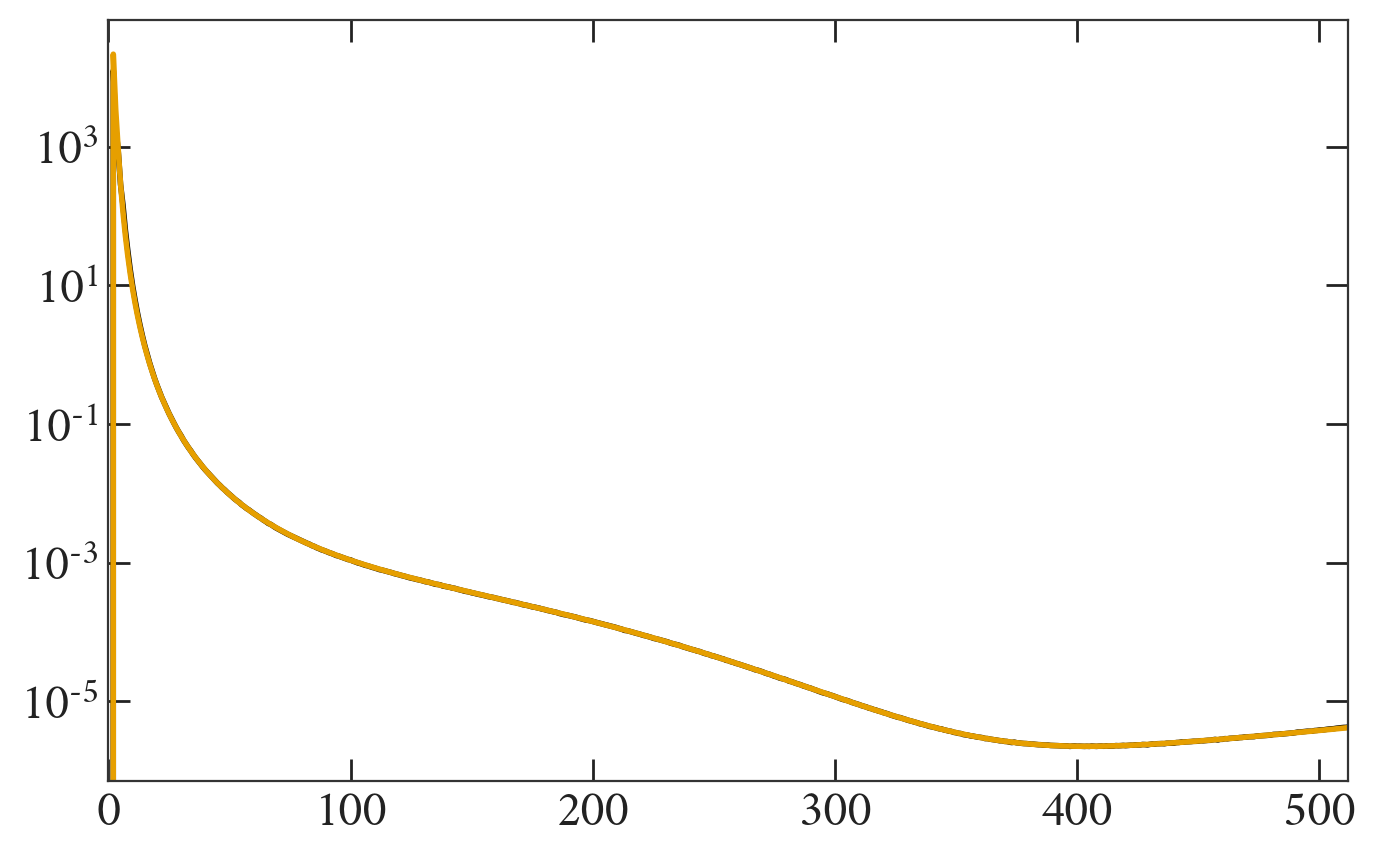

In [28]:
plt.plot(diag(empirical_cov), "-")
plt.plot(diag(parent(C)), "-")
xlim(0, 2nside)
yscale("log")

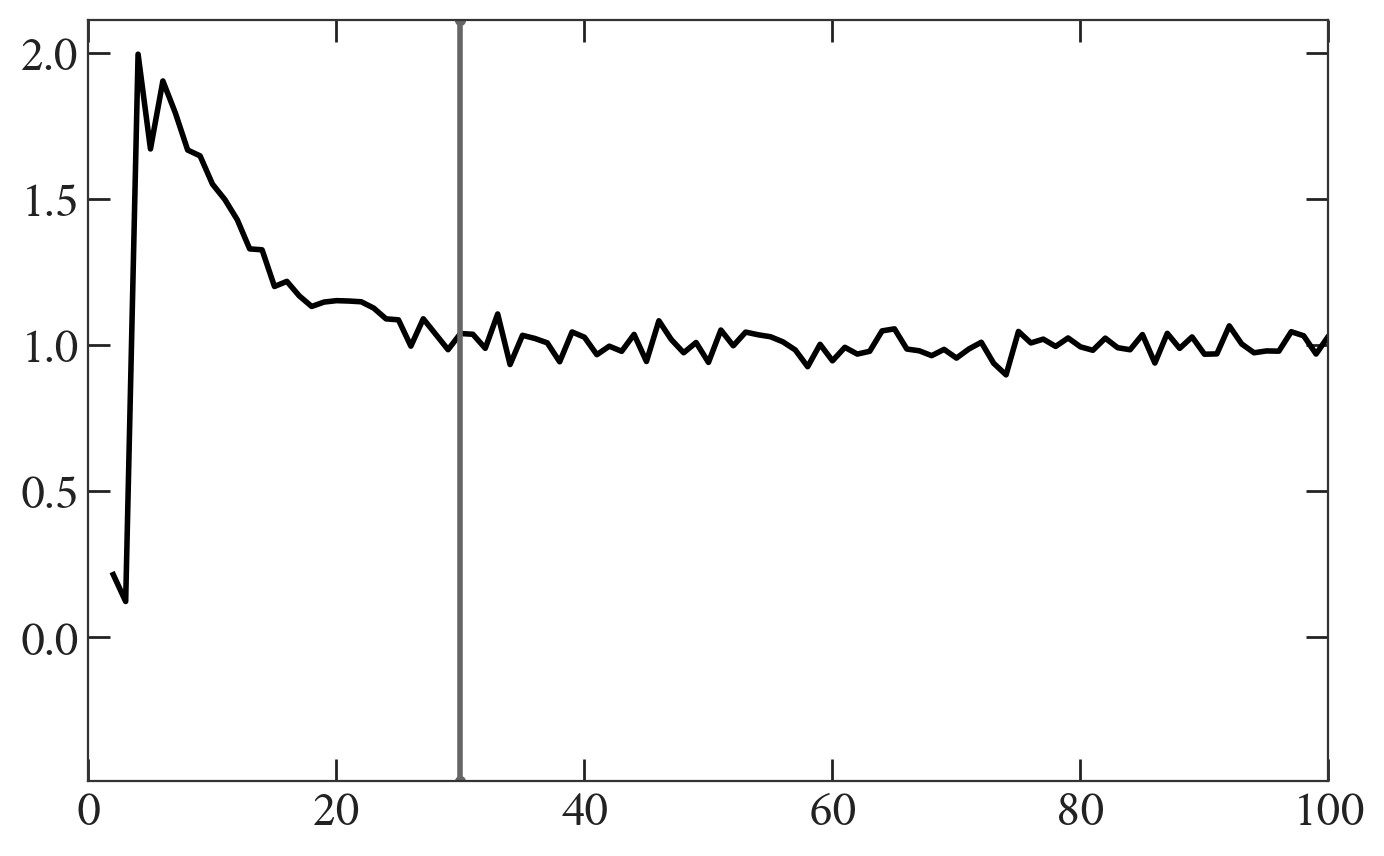

(0.0, 100.0)

In [33]:
plt.plot(diag(empirical_cov, 2) ./ diag(parent(C), 2), "-")
xlim(0, 2nside)
axvline(30)
xlim(0,100)
# yscale("log")